In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.model import InkDetector
from utils.config import Config
from utils.dataloader import load_test_data
import pickle
from scipy.ndimage import zoom
%matplotlib inline


In [2]:
data = np.load("/media/jeff/Seagate/vesuvius-zarrs/scroll4_bottomleft.npz")
test_volume = data['stack']

In [ ]:
class TestVisualizer:
    def __init__(self, config):
        self.config = config

    def load_model_and_run_inference(self, model_path):
        """Load model and run inference on test data"""
        print("Loading model...")
        model = InkDetector(self.config)
        model.load_state_dict(torch.load(model_path, map_location=self.config.device, weights_only=False))
        model.eval()
        model.to(self.config.device)

        
        return self.add_test_figures(model, test_volume)

    def add_test_figures(self, model, test_volume):
        """
        Run test evaluation and create one combined figure with all depth blocks
        No ground truth overlay for test data
        """
        print("Starting test figure generation...")
        model.eval()
        
        # Calculate number of depth blocks
        D = test_volume.shape[0]
        num_depth_blocks = (D - self.config.data.depth) // int(self.config.data.depth // 2) + 1
        
        all_predictions_data = []
        
        for block_idx in range(num_depth_blocks):
            print(f"Processing depth block {block_idx + 1}/{num_depth_blocks} for test...")
            depth_start = block_idx * int(self.config.data.depth // 2)
            depth_end = min(depth_start + self.config.data.depth, D)
            
            # Skip if depth_start or depth_end is out of bounds
            if depth_start >= D or depth_end > D or depth_start < 0:
                continue
            
            # Check if the depth range is valid
            if depth_end - depth_start != self.config.data.depth:
                print(f"Skipping block {block_idx + 1} due to mismatched depth dimensions.")
                continue
            
            predictions = self._process_volume_depth_block(
                model, test_volume, "test", depth_start, depth_end
            )
            
            all_predictions_data.append((predictions, depth_start, depth_end))
        
        if all_predictions_data:
            # Create one combined figure with all test depth blocks (no ground truth overlay)
            print(f"got {len(all_predictions_data)} depth blocks for test")

            fig = self._create_combined_test_figure(all_predictions_data, len(all_predictions_data))

            return fig
        else:
            print("No valid depth blocks found for test data.")
            return None

    def _create_combined_test_figure(self, all_predictions_data, num_depth_blocks, scale_factor=0.3):
        """Create combined test figure with predictions (no ground truth overlay)"""
        
        cols = 2
        rows = (num_depth_blocks + 1) // 2
        
        fig_width = 10
        fig_height = 3 * rows
        
        fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for block_idx, (predictions, depth_start, depth_end) in enumerate(all_predictions_data):
            ax1 = axes[block_idx // cols, block_idx % cols]
            scaled_predictions = zoom(predictions, scale_factor, order=1)
            im = ax1.imshow(scaled_predictions, cmap='inferno', vmin=0, vmax=1, aspect='equal')
            ax1.set_title(f'Depth Block {depth_start}-{depth_end}', fontsize=9)
            ax1.axis('off')

        
        plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)
        return fig

    def _process_volume_depth_block(self, model, volume, volume_name, depth_start, depth_end):
        """Helper function to process a single volume at a specific depth range"""
        D, H, W = volume.shape
        
        prediction_map = np.zeros((H, W), dtype=np.float32)
        count_map = np.zeros((H, W), dtype=np.float32)
        
        # Create list of all tile coordinates
        tile_coords = []
        for y in range(0, H - self.config.data.tile_size + 1, self.config.data.tile_size):
            for x in range(0, W - self.config.data.tile_size + 1, self.config.data.tile_size):
                tile_coords.append((y, x))
        
        # Pre-allocate tensor on GPU to avoid repeated allocations
        if torch.cuda.is_available():
            block_tensor = torch.zeros(
                (1, 1, self.config.data.depth, self.config.data.tile_size, self.config.data.tile_size),
                dtype=torch.float32,
                device=self.config.device
            )
        else:
            block_tensor = torch.zeros(
                (1, 1, self.config.data.depth, self.config.data.tile_size, self.config.data.tile_size),
                dtype=torch.float32
            )
        with torch.no_grad():
            for y, x in tqdm(tile_coords, desc=f"Processing {volume_name} volume (depth {depth_start}-{depth_end})"):
                # Extract block from the specified depth range
                block = volume[depth_start:depth_end, y:y+self.config.data.tile_size, x:x+self.config.data.tile_size]
                # print(f"extracted {block.shape} from {depth_start}:{depth_end}")
                
                if block.shape != (self.config.data.depth, self.config.data.tile_size, self.config.data.tile_size):
                    # Clean up before returning
                    del block_tensor
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    return np.zeros((H, W), dtype=np.float32)
                
                # Copy data to pre-allocated tensor instead of creating new ones
                block_tensor[0, 0] = torch.from_numpy(block).float()
                
                logits = model(block_tensor)
                pred = torch.sigmoid(logits).item()
                
                prediction_map[y:y+self.config.data.tile_size, x:x+self.config.data.tile_size] += pred
                count_map[y:y+self.config.data.tile_size, x:x+self.config.data.tile_size] += 1
        
        # Clean up GPU memory
        del block_tensor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Normalize predictions
        prediction_map = np.divide(prediction_map, count_map, where=count_map>0)
        return prediction_map

Loading model...
Starting test figure generation...
Processing depth block 1/15 for test...


Processing test volume (depth 0-8): 100%|██████████| 7700/7700 [00:22<00:00, 343.41it/s]


Processing depth block 2/15 for test...


Processing test volume (depth 4-12): 100%|██████████| 7700/7700 [00:18<00:00, 410.08it/s]


Processing depth block 3/15 for test...


Processing test volume (depth 8-16): 100%|██████████| 7700/7700 [00:20<00:00, 373.20it/s]


Processing depth block 4/15 for test...


Processing test volume (depth 12-20): 100%|██████████| 7700/7700 [00:20<00:00, 369.14it/s]


Processing depth block 5/15 for test...


Processing test volume (depth 16-24): 100%|██████████| 7700/7700 [00:21<00:00, 360.29it/s]


Processing depth block 6/15 for test...


Processing test volume (depth 20-28): 100%|██████████| 7700/7700 [00:21<00:00, 361.19it/s]


Processing depth block 7/15 for test...


Processing test volume (depth 24-32): 100%|██████████| 7700/7700 [00:21<00:00, 360.84it/s]


Processing depth block 8/15 for test...


Processing test volume (depth 28-36): 100%|██████████| 7700/7700 [00:21<00:00, 360.18it/s]


Processing depth block 9/15 for test...


Processing test volume (depth 32-40): 100%|██████████| 7700/7700 [00:21<00:00, 361.40it/s]


Processing depth block 10/15 for test...


Processing test volume (depth 36-44): 100%|██████████| 7700/7700 [00:21<00:00, 356.27it/s]


Processing depth block 11/15 for test...


Processing test volume (depth 40-48): 100%|██████████| 7700/7700 [00:21<00:00, 358.19it/s]


Processing depth block 12/15 for test...


Processing test volume (depth 44-52): 100%|██████████| 7700/7700 [00:21<00:00, 357.10it/s]


Processing depth block 13/15 for test...


Processing test volume (depth 48-56): 100%|██████████| 7700/7700 [00:21<00:00, 358.91it/s]


Processing depth block 14/15 for test...


Processing test volume (depth 52-60): 100%|██████████| 7700/7700 [00:21<00:00, 357.75it/s]


Processing depth block 15/15 for test...


Processing test volume (depth 56-64): 100%|██████████| 7700/7700 [00:21<00:00, 357.94it/s]


got 15 depth blocks for test


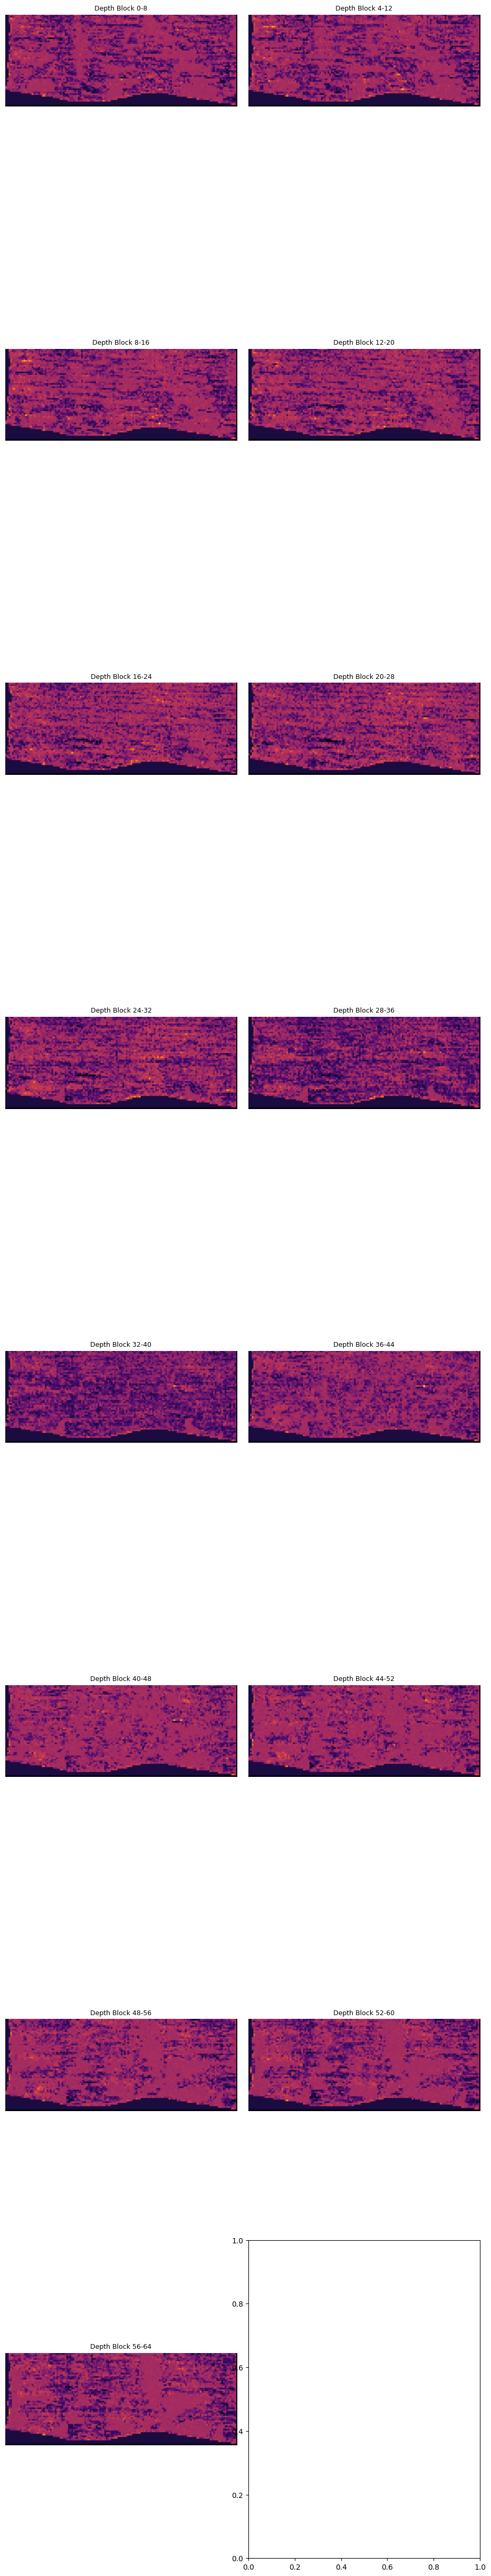

In [4]:
test_visualizer = TestVisualizer(Config())
fig = test_visualizer.load_model_and_run_inference("models/model_epoch_50.pth")
# show the figure in matplotlib
if fig is not None:
    plt.show(fig)
else:
    print("No figure to show, check the logs for details.")

